In [1]:
import sqlite3
import pandas as pd
import numpy as np                   # Para cosas de álgebra lineal
import matplotlib.pyplot as plt      # Para gráficos
import seaborn as sns                # Para gráficos lindos :^)
sns.set_style("darkgrid")
from sklearn import linear_model     # Para CML
import warnings
warnings.filterwarnings('ignore')  # Cállese, hombre horrible!

import sys
sys.path.append('..')
from utils import *

conn = sqlite3.connect('../vuelos.db')

In [2]:
df = query_db('''
select o.deptime as DepartureTime, avg(o.DepDelay) as TotalDelay
from ontime o
where deptime != "NA"
and year >= 2006
group by deptime
order by deptime asc;
''', conn)
df.describe()

,Unnamed: 0,DepartureTime,TotalDelay
count,1552.000000,1552.000000,1552.000000
mean,775.500000,1275.870490,41.849834
std,448.168123,749.074559,64.498269
min,0.000000,1.000000,-7.270160
25%,387.750000,628.750000,6.562018
50%,775.500000,1256.500000,13.857474
75%,1163.250000,1924.250000,56.269275
max,1551.000000,2930.000000,778.000000


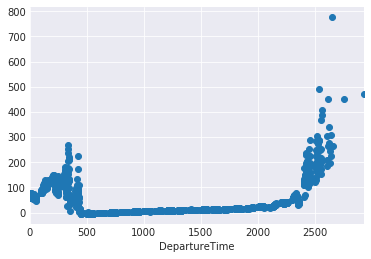

In [3]:
ax = sns.tsplot(time=df['DepartureTime'], data=df['TotalDelay'], interpolate=False)
plt.show()

Analizando todos los delays sumados

In [4]:
df2 = query_db('''
select o.deptime as DepartureTime, count(*) as AmountOfDelays
from ontime o
where deptime != "NA" and (o.ArrDelay + o.DepDelay + o.CarrierDelay + o.WeatherDelay + o.NASDelay
+ o.SecurityDelay + o.LateAircraftDelay) >= 15
group by deptime
order by deptime asc;
''', conn)

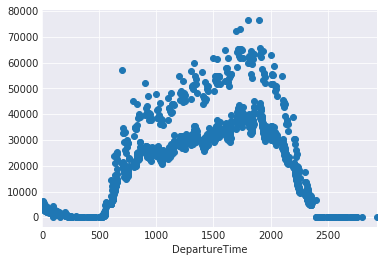

In [5]:
ax = sns.tsplot(time=df2['DepartureTime'], data=df2['AmountOfDelays'], interpolate=False)
plt.show()

In [6]:
df3 = query_db('''
select substr(o.deptime,0,2) as hora, count(*)*1.0/o2.amount as AmountOfDelays
from ontime o
join
(select substr(deptime,0,2) as hora, count(*) as amount from ontime where hora != "NA" and year >= 2005 group by hora)
as o2 on o2.hora = hora
where hora != "NA" and (o.ArrDelay + o.DepDelay + o.CarrierDelay + o.WeatherDelay + o.NASDelay
+ o.SecurityDelay + o.LateAircraftDelay) >= 15
and year >= 2005
group by  substr(o.deptime,0,2)
order by hora asc;
''', conn)
df3

,Unnamed: 0,hora,AmountOfDelays
0,0,1,101.023798
1,1,2,25.360820
2,2,3,0.188797
3,3,4,0.156390
4,4,5,0.630553
5,5,6,3.495236
6,6,7,4.902508
7,7,8,6.138353
8,8,9,6.989114


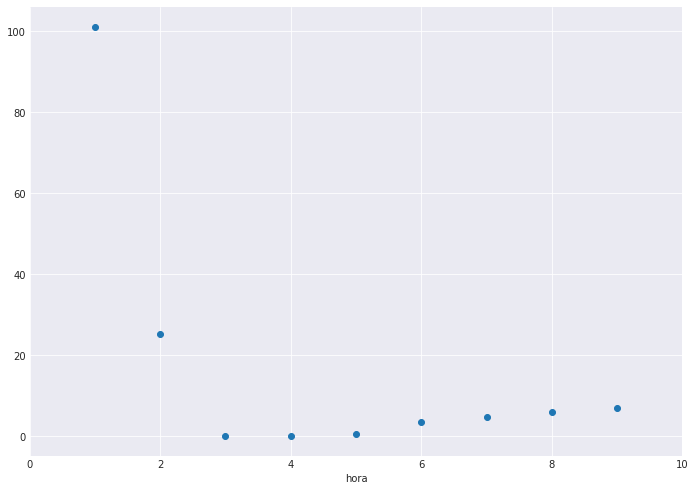

In [7]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.tsplot(ax = ax, time=df3['hora'], data=df3['AmountOfDelays'], interpolate=False)
#sns.boxplot(x=df3['hora'], y=df3['AmountOfDelays'])
plt.show()

# Análisis de delay de salida según la hora de salida programada
Vamos a analizar el porcentaje de delays para cada franaja horaria, es decir:
* De las 00:00 a 01:00
* De las 01:00 a 02:00
* ....
* Hasta 23:00 a 00:00

In [8]:
def humanize(num, suffix=''):
    for unit in ['','K','M']:
        if abs(num) < 1000.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1000.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [9]:
df4 = query_db('''
select o.CRSDeptime as CRSDeptime, count(*)*1.0/o2.amount as DelayPercentage, o2.amount as TotalAmount
from ontime o
join (select CRSDeptime, count(*) as amount from ontime where CRSDeptime != "NA" and year >= {year} group by CRSDeptime)
  as o2 on o2.CRSDeptime = o.CRSDeptime
where o.CRSDeptime != "NA"  and
  o.DepDelay >= 15
  and year >= {year}
group by o.CRSDeptime
order by o.CRSDeptime asc;
'''.format(year=2003), conn)

# Parseamos la hora que está en formato HHMM
df4['hora'] = pd.Series([int(str(s).rjust(4, '0')[0:2]) for s in df4['CRSDeptime']])
df4[df4['hora'] == 24] = 0

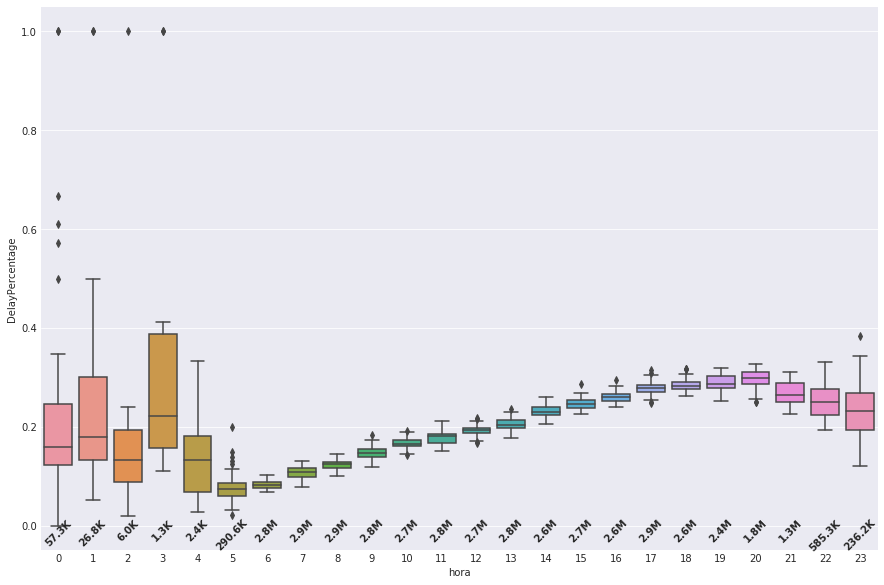

In [10]:
fig_dims = (15, 10)
plt.figure(figsize=fig_dims)

sns.boxplot(x=df4['hora'], y=df4['DelayPercentage'])

amounts = df4.groupby('hora')['TotalAmount'].aggregate(['sum']).reset_index()

pos = range(len(amounts))
for tick in pos:
    plt.text(pos[tick], 0, humanize(amounts.loc[tick]['sum']), 
            horizontalalignment='center', size='medium', weight='semibold', rotation=45)
plt.show()

# Tomamos promedio por franja horaria en lugar de por minuto

In [11]:
df_delays_hora = query_db('''
select o.CRSDeptime as CRSDeptime, count(*) as TotalOfDelays
from ontime o
where o.CRSDeptime != "NA"  and
  o.DepDelay >= 15
  and year >= {year}
group by o.CRSDeptime;
'''.format(year=2003), conn)

# Parseamos la hora que está en formato HHMM
df_delays_hora['hora'] = pd.Series([int(str(s).rjust(4, '0')[0:2]) for s in df_delays_hora['CRSDeptime']])
df_delays_hora[df_delays_hora['hora'] == 24] = 0

In [12]:
df_total_hora = query_db('''
select o.CRSDeptime as CRSDeptime, count(*) as TotalOfFlights
from ontime o
where o.CRSDeptime != "NA"
  and year >= {year}
group by o.CRSDeptime;
'''.format(year=2003), conn)

# Parseamos la hora que está en formato HHMM
df_total_hora['hora'] = pd.Series([int(str(s).rjust(4, '0')[0:2]) for s in df_total_hora['CRSDeptime']])
df_total_hora[df_total_hora['hora'] == 24] = 0

In [13]:
# Auxiliares
def deptime_to_hour(deptime):
    return int(str(deptime).rjust(4, '0')[0:2])

def day_hour_to_month_hour(hour, day):
    return hour + (day -1) * 24

def add_hour_column(df):
    df['hora'] = pd.Series([deptime_to_hour(deptime) for deptime in df['CRSDeptime']])


In [14]:
def get_delay_percentage(partial, total):
    for i, row in total.iterrows():
        d = partial.loc[partial.hora == i]['TotalOfDelays']
        if not d.empty:
            if d.iloc[0] > row['TotalOfFlights']: 
                
                yield 1
            else:
                yield d.iloc[0]/row['TotalOfFlights']
        else:
            #print("No encontre en", i)
            yield 0

In [15]:
# Agregamos una columna que tenga la hora del mes
add_hour_column(df_delays_hora)
add_hour_column(df_total_hora)

# Compute Data
delays = df_delays_hora.groupby('hora', as_index=False)['TotalOfDelays'].sum()
totals = df_total_hora.groupby('hora', as_index=False)['TotalOfFlights'].sum()

y = list(get_delay_percentage(delays, totals))

#data, axis = remove_outliers(y,list(totals['hora']))

df_final = pd.DataFrame({'Hour': list(totals['hora']), 'DelayPercentage': y})

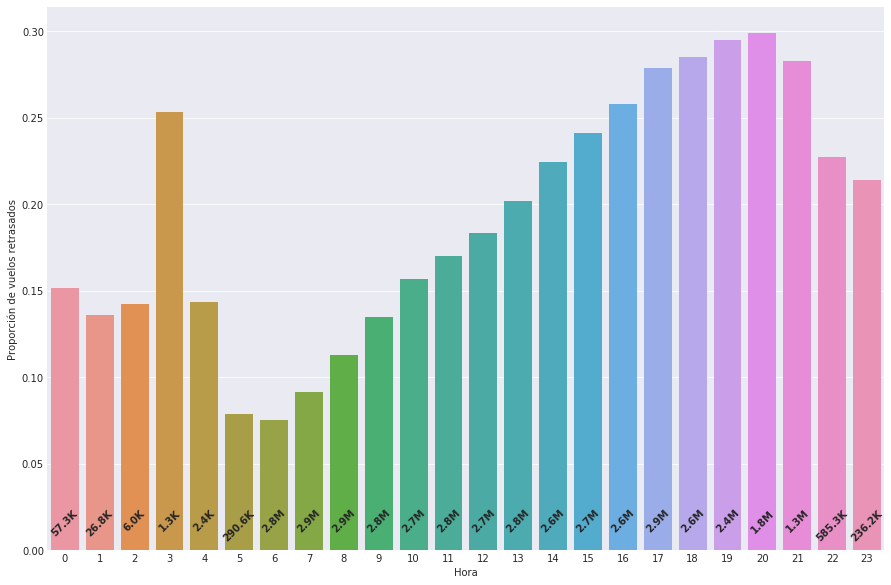

In [16]:
fig_dims = (15, 10)
plt.figure(figsize=fig_dims)

sns.barplot(x=df_final['Hour'], y=df_final['DelayPercentage'])

#amounts = df_final.groupby('Hour')['TotalAmount'].aggregate(['sum']).reset_index()

pos = range(len(amounts))
for tick in pos:
    plt.text(pos[tick], 0.020000000000161803398874988, humanize(amounts.loc[tick]['sum']), 
            horizontalalignment='center', size='medium', weight='semibold', rotation=45)
plt.xlabel('Hora')
plt.ylabel('Proporción de vuelos retrasados')
plt.show()

## Analizamos ahora cada día de la semana en particular
Queremos ver si el comportamiento observado es similar todos los días.

In [17]:
dfs2 = []
for i in range(1,8):
    df_temp = query_db('''
select o.CRSDeptime as CRSDeptime, count(*)*1.0/o2.amount as AmountOfDelays, o2.amount as TotalAmount
from ontime o
join (select CRSDeptime, count(*) as amount from ontime where CRSDeptime != "NA" and year >= {year} and DayOfWeek = {day} group by CRSDeptime)
  as o2 on o2.CRSDeptime = o.CRSDeptime
where o.CRSDeptime != "NA"  and
  o.DepDelay >= 15
  and year >= {year} and o.DayOfWeek = {day}
group by o.CRSDeptime
order by o.CRSDeptime asc;
'''.format(year=2007, day=i), conn)
    df_temp['hora'] = pd.Series([int(str(s).rjust(4, '0')[0:2]) for s in df_temp['CRSDeptime']])
    df_temp[df_temp['hora'] == 24] = 0
    dfs2.append(df_temp)

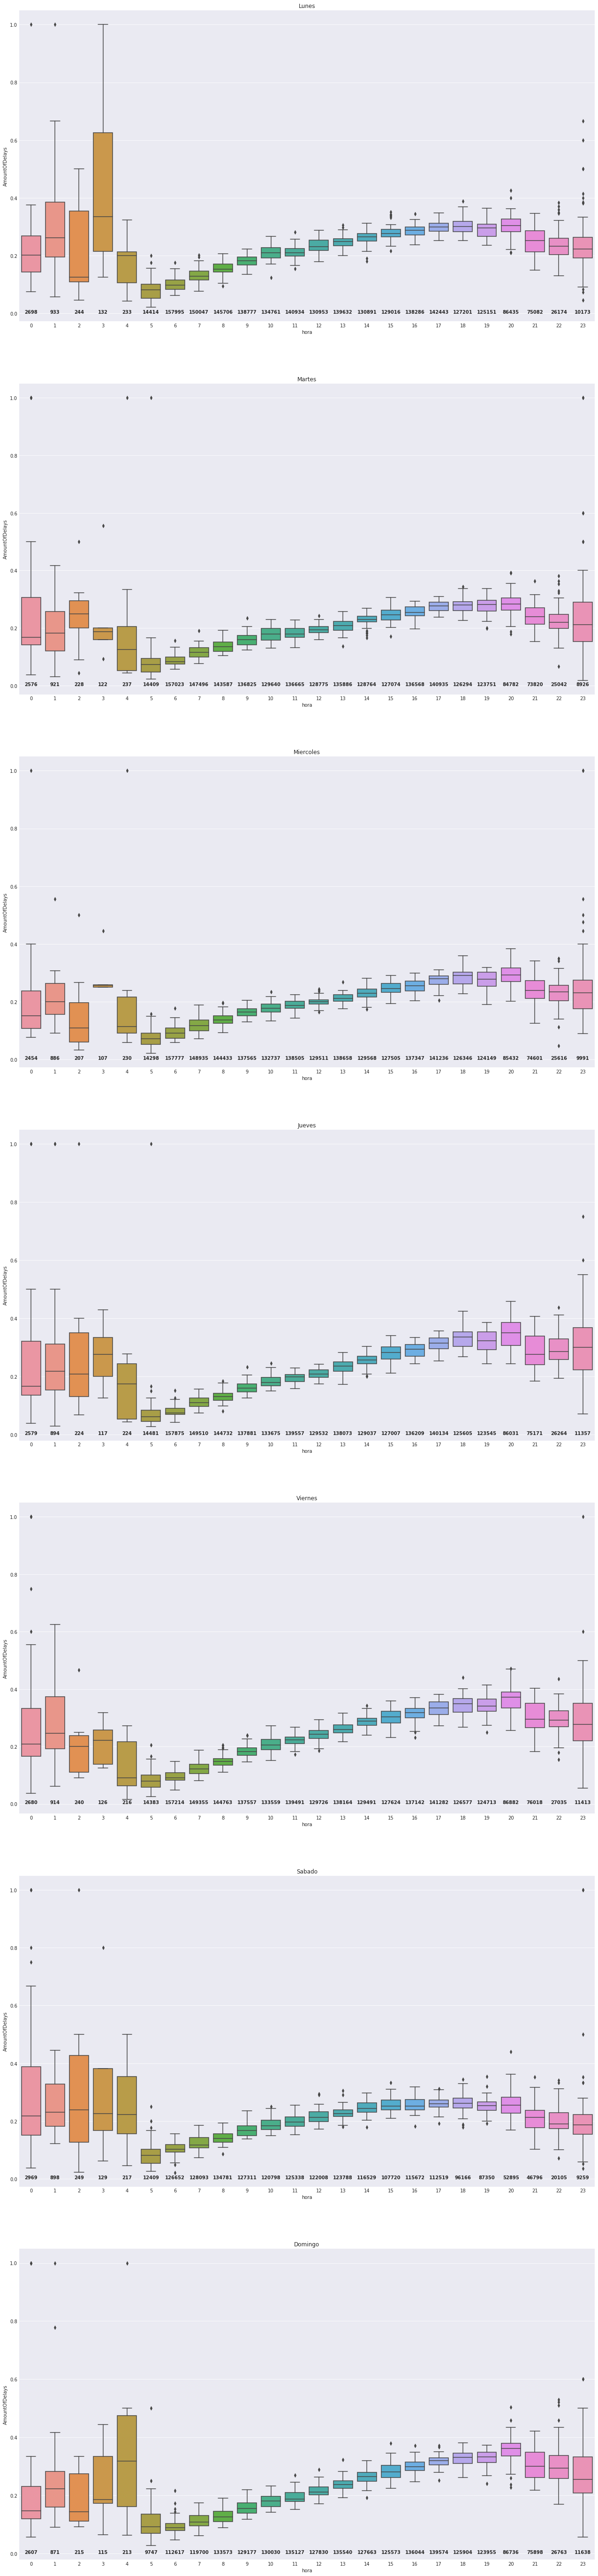

In [18]:
fig, ax = plt.subplots(7, figsize=(22, 100))
daysOfWeek = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
for i, day in enumerate(dfs2):
    ax[i].set_title(daysOfWeek[i])
    #sns.boxplot(ax=ax[i], x=dfs2[i]['hora'], y=dfs2[i]['AmountOfDelays'], hue=dfs2[i]['TotalAmount'])
    sns.boxplot(ax=ax[i], x="hora", y="AmountOfDelays", data=dfs2[i])
    #sns.swarmplot(ax=ax[i], x="hora", y="AmountOfDelays", data=dfs2[i], color=".25")
    
    amounts = dfs2[i].groupby('hora')['TotalAmount'].aggregate(['sum']).reset_index()
    pos = range(len(amounts))
    for tick,label in zip(pos,ax[i].get_xticklabels()):
        ax[i].text(pos[tick], 0, amounts.loc[tick]['sum'], 
                horizontalalignment='center', size='medium', weight='semibold')
plt.show()

## Queda pendiente de este analisis
* Correr la query con todos los años
* Tomar más granular la división del tiempo, e.g., et
* Hacer CML. Por ejemplo, entrenar con todos los horarios menos las "11" y ver como funciona la predicción.

### Intentaremos hacer CML para todo un año, con el objetivo de predecir el porcentaje de delays dada una hora de un día de un mes.

In [19]:
# Auxiliares
def deptime_to_hour(deptime):
    return int(str(deptime).rjust(4, '0')[0:2])

def day_hour_to_month_hour(hour, day):
    return hour + (day -1) * 24

def add_hour_column(df):
    df['hora'] = pd.Series([day_hour_to_month_hour(deptime_to_hour(deptime), day) for deptime, day in zip(df['CRSDepTime'], df['DayofMonth'])])
    
def remove_outliers(data, axis):
    i_to_remove = []
    removes = 0
    for i in range(0,len(data)-1):
        if i < 7:
            med = obtain_med(data[i:i+7])
        elif i > len(data)-8:
            med = obtain_med(data[i-7:i])
        else:
            med = obtain_med(data[i-3:i+4])
        if data[i] >= med*1.5 or data[i] == 0:
            i_to_remove.append(i)
    for i in i_to_remove:
        data.pop(i-removes)
        axis.pop(i-removes)
        removes += 1
    return data, axis
            
def obtain_med(data_list):
    acum = 0
    for elem in data_list:
        acum += elem
    return acum/len(data_list)

def get_delay_percentage(partial, total):
    for i, row in total.iterrows():
        d = partial.loc[partial.hora == i]['TotalOfDelays']
        if not d.empty:
            if d.iloc[0] > row['TotalOfFligths']: 
                yield 1
            else:
                yield d.iloc[0]/row['TotalOfFligths']
        else:
            #print("No encontre en", i)
            yield 0
            
def get_delays_from_month_and_year(year, month):
    # Delays por (hora, dia)
    delaysByDay = query_db('''
    select o.CRSDepTime, o.DayofMonth, count(*) as TotalOfDelays
    from ontime o
    where o.CRSDeptime != "NA"  and
      o.DepDelay >= 15
      and year >= {year}
      and month = {month}
    group by o.CRSDepTime, o.DayofMonth;
    '''.format(year=year, month=month), conn)

    # Cantidad de vuelos por (hora, dia)
    totalsByDay = query_db('''
    select o.CRSDepTime, o.DayOfMonth, count(*) as TotalOfFligths
    from ontime o
    where o.CRSDeptime != "NA"
      and year >= {year}
      and month = {month}
    group by o.CRSDepTime, o.DayOfMonth;
    '''.format(year=year, month=month), conn)
    
    # Agregamos una columna que tenga la hora del mes
    add_hour_column(delaysByDay)
    add_hour_column(totalsByDay)
    delaysByDayClean = delaysByDay.drop(columns=['CRSDepTime'])
    totalsByDayClean = totalsByDay.drop(columns=['CRSDepTime'])
    
    # Compute Data
    delays = delaysByDayClean.groupby('hora', as_index=False)['TotalOfDelays'].sum()
    totals = totalsByDayClean.groupby('hora', as_index=False)['TotalOfFligths'].sum()
    #print(delays, totals)
    y = list(get_delay_percentage(delays, totals))
    
    data, axis = remove_outliers(y,list(totals['hora']))
    
    return pd.DataFrame({'HourOfMonth': axis, 'DelayPerc': data})

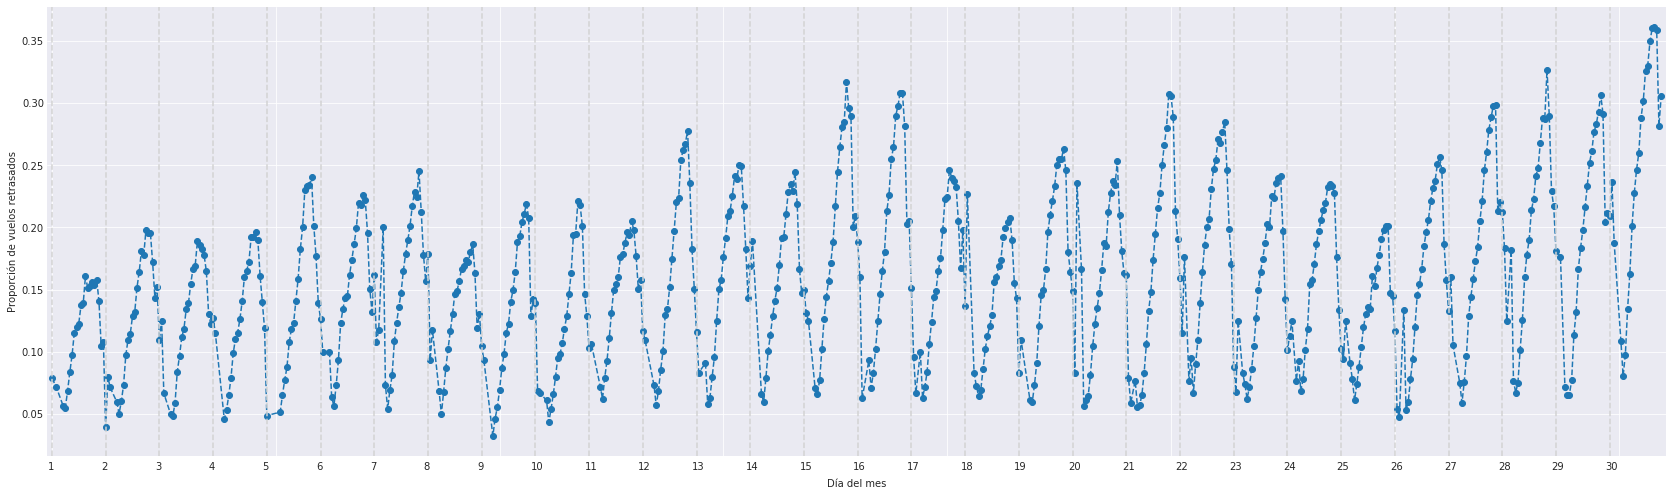

In [20]:
def plot_delays(df, ax=None):
    plt.figure(figsize=(29, 8.27))
    days = (df['HourOfMonth'].iloc[-1] + 1) // 24
    ax = sns.tsplot(time=list(df['HourOfMonth']), data=df['DelayPerc'], interpolate=False, marker='o', linestyle='--', ax=ax)
    for i in range(days):
        ax.axvline(i*24 , color='lightgray', linestyle='--')
        ax.text(i*24 - 2, 0.005, i+1)
    ax.set_ylabel('Proporción de vuelos retrasados')
    ax.set_xlabel('Día del mes')
    ax.xaxis.set_label_coords(0.5, -0.05)
    ax.tick_params(bottom='off', labelbottom='off')   # hide xticks
    ax.legend(loc='upper center', shadow=True)
    return ax

df = get_delays_from_month_and_year(2002, 11)
plot_delays(df)
plt.show()

# Predicción

In [21]:
def armar_matriz_A(s, funcion):
    temp = []
    for t in s:
        temp.append(funcion(t))
    return np.array(temp)

def entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion, funcion, x='x', y='y', ax=None):
    ax = plot_delays(df, ax=ax)

    # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    regr = linear_model.LinearRegression(fit_intercept=False)

    ## Entreno el modelo
    
    # Armo la matriz A de features
    df_entrenamiento = df[df[x].isin(rango_entrenamiento)]
    A = armar_matriz_A(df_entrenamiento[x], funcion)
    
    # 'Fiteo' los datos de entrenamiento
    regr.fit(A, df_entrenamiento[y])
    
    # Grafico la aproximacion
    df_entrenamiento['pred'] = regr.predict(A)
    sns.tsplot(ax=ax, time=list(df_entrenamiento[x]), data=df_entrenamiento['pred'], value='Entrenamiento', color='red', linewidth=3)

    ## Realizo predicciones
    
    # Armo la matriz A de features
    df_prediccion = df[df[x].isin(rango_prediccion)]
    A = armar_matriz_A(df_prediccion[x], funcion)
    
    # Predigo los datos de testeo
    df_prediccion['pred'] = regr.predict(A)
    
    # Grafico la prediccion
    sns.tsplot(ax=ax, time=list(df_prediccion[x]), data=df_prediccion['pred'], value='Predicción', color='green', linewidth=3)

    ## Calculo el Error Cuadrático Medio
    ECM = sum((df_prediccion['pred'] - df_prediccion[y])**2) / df_prediccion.shape[0]
    
    # Restaura rango de X completo
    ax.set_xlim(0, df[x].iloc[-1])
    
    return ECM, ax

def predict(year, month, start_at, train_days, test_days, func, ax=None):
    df = get_delays_from_month_and_year(year, month)
    rango_entrenamiento = list(range(start_at * 24, (start_at + train_days) * 24 + 1))
    rango_prediccion = list(range((start_at + train_days) * 24, (start_at + train_days + test_days) * 24))
    #print("Rango entrenamiento: {} .. {}".format(rango_entrenamiento[0], rango_entrenamiento[-1]))
    #print("Rango predicción: {} .. {}".format(rango_prediccion[0], rango_prediccion[-1]))
    return entrenar_y_predecir_en_rangos(df, rango_entrenamiento, rango_prediccion,
                                         func, ax=ax, x='HourOfMonth', y='DelayPerc')

Probamos primero con el mes de noviembre, con una familia de funciones que incluyen una constante, una lineal (dado la aparente tendencia a incrementar a medida que avanza el mes), y una sinusoide (por la periodicidad de los días)

ECM: 0.004978627594097826


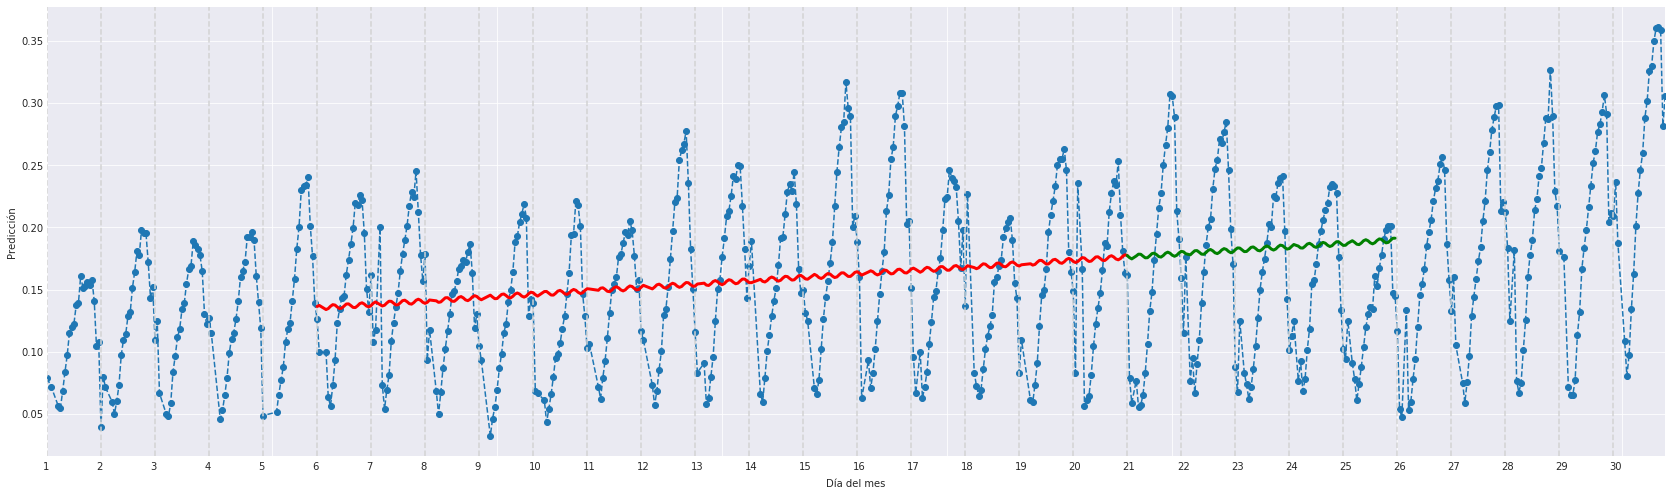

In [22]:
func = lambda t: [np.sin(t), t, 1]
ecm, ax = predict(2002, 11, 5, 15, 5, func)
print("ECM: {}".format(ecm))
plt.show()

Elegiendo una frencuencia apropiada para la función sinosoidal, la aproximación mejora:

In [23]:
freq = 0.26204

ECM: 0.0011989982246862466


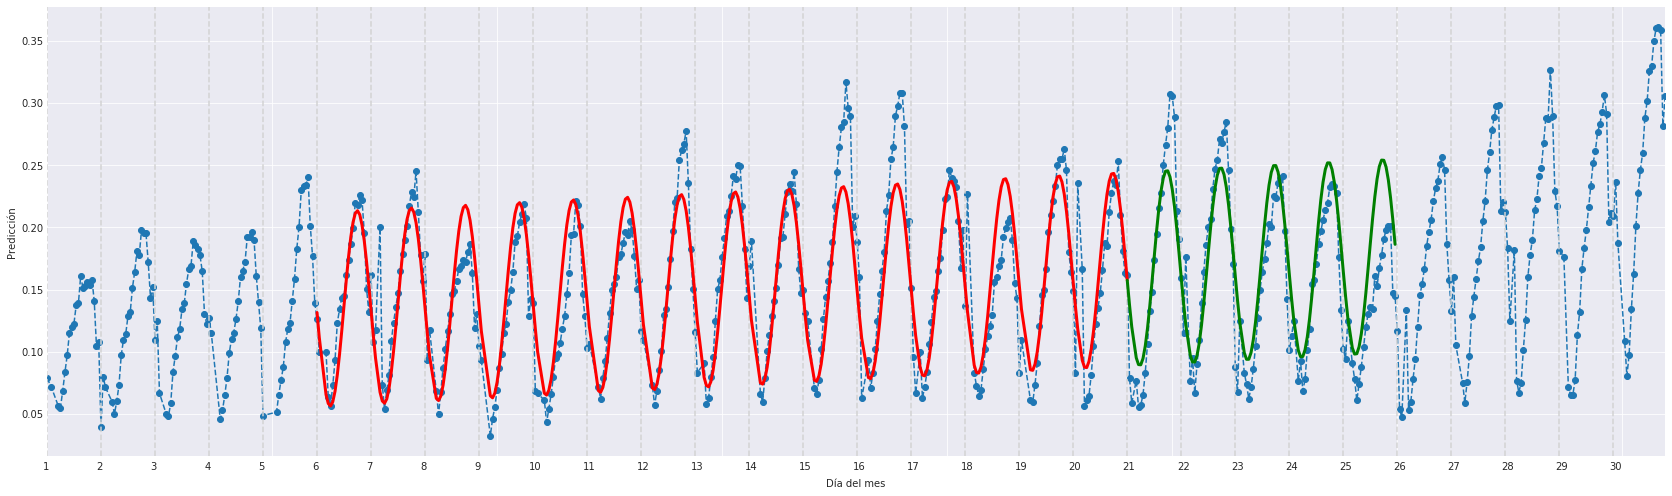

In [24]:
func = lambda t: [np.sin(freq * t), t, 1]
ecm, _ = predict(2002, 11, 5, 15, 5, func)
print("ECM: {}".format(ecm))
plt.show()
None

Hacemos validación cruzada con $k=5$ de a 5 días de paso.

In [25]:
def crossval(year, month, start_at, func, k=3, step=5):
    ax = None
    ecms = []
    for i in range(k):
        ecm, ax = predict(year, month, start_at, (i+1) * step, step, func, ax=ax)
        ecms.append(ecm)
    return np.array([ecms])

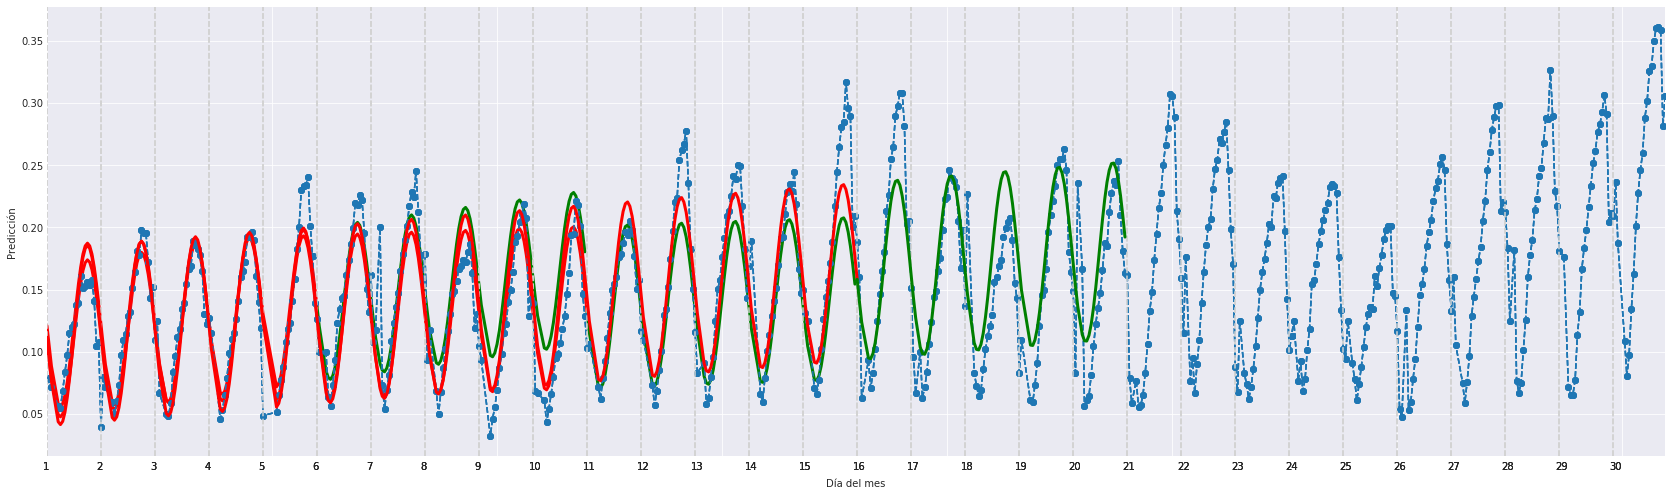

ECM Promedio: 0.001215885145829357


In [26]:
ecms = crossval(2002, 11, 0, func)
plt.show();
print("ECM Promedio: {}".format(ecms.mean()))

Por otro lado, si analizamos el mes de enero, vemos que la tendencia de delays está invertida: hay más retrasos a comienzo del año debido a las festividades de año nuevo y navidad. Si se realiza CML sobre estos primeros 10 días, la recta afecta de manera negativa:

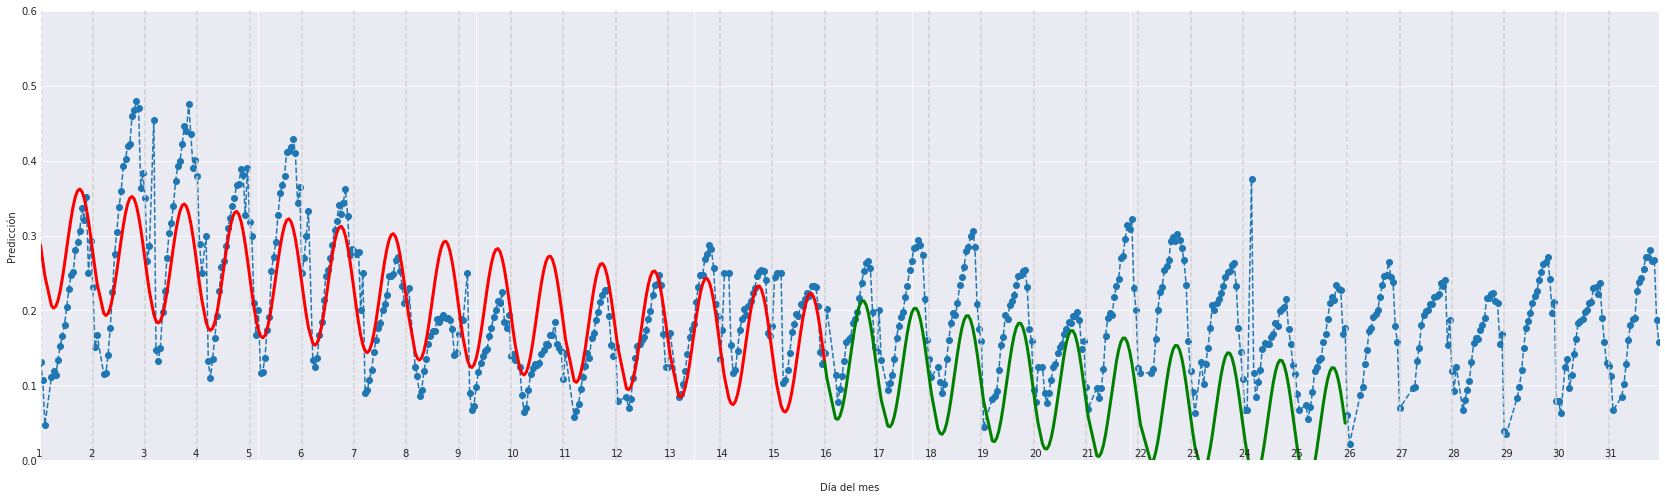

ECM: 0.009393107401872885


In [27]:
func = lambda t: [np.sin(freq * t), t, 1]
ecm, _ = predict(2002, 1, 0, 15, 10, func)
plt.ylim(0, 0.6)
plt.show()
print("ECM: {}".format(ecm))

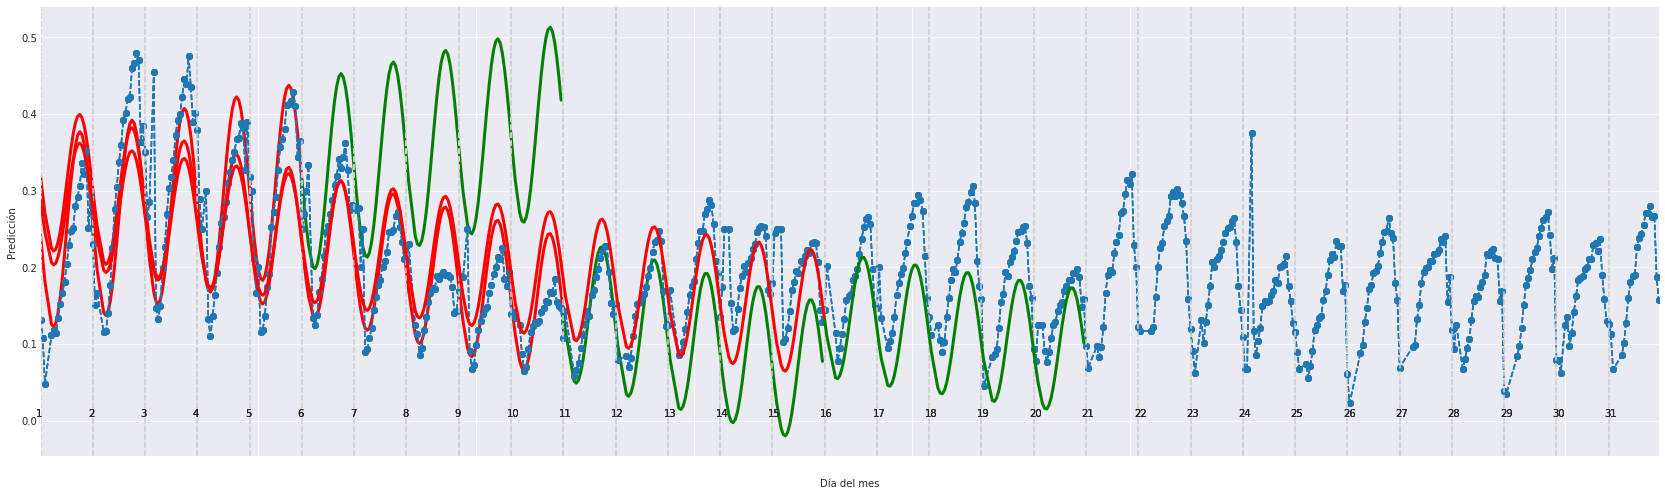

ECM Promedio: 0.01721808179683797


In [28]:
ecms = crossval(2002, 1, 0, func)
plt.show();
print("ECM Promedio: {}".format(ecms.mean()))

Eliminando la recta, la pendiente se corrige, aunque la aproximación sigue siendo no muy buena, porque los primeros días no son representativos del retraso en el resto de los días del mes.

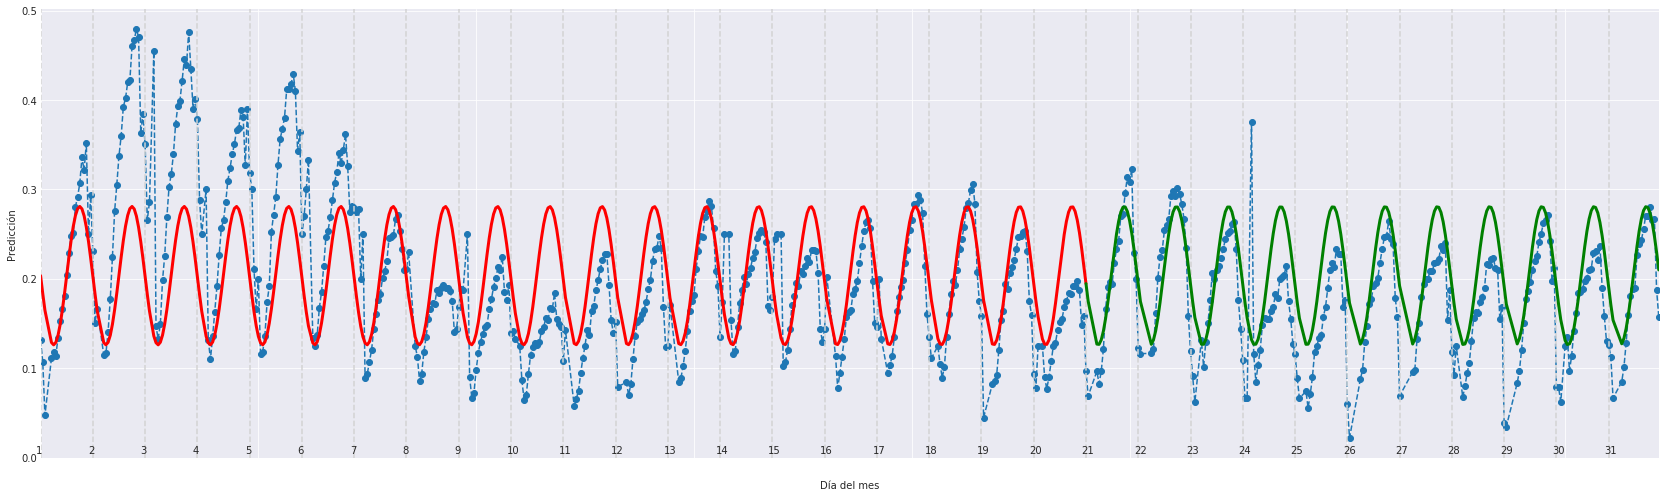

ECM: 0.002848288854975742


In [29]:
func = lambda t: [np.sin(freq * t), 1]
ecm, _ = predict(2002, 1, 0, 20, 11, func)
#plt.ylim(0, 0.6)
plt.show()
print("ECM: {}".format(ecm))

Analizamos luego Abril, y los resultados son mejores dado que no hay demasiadas fluctuaciones a lo largo del mes.

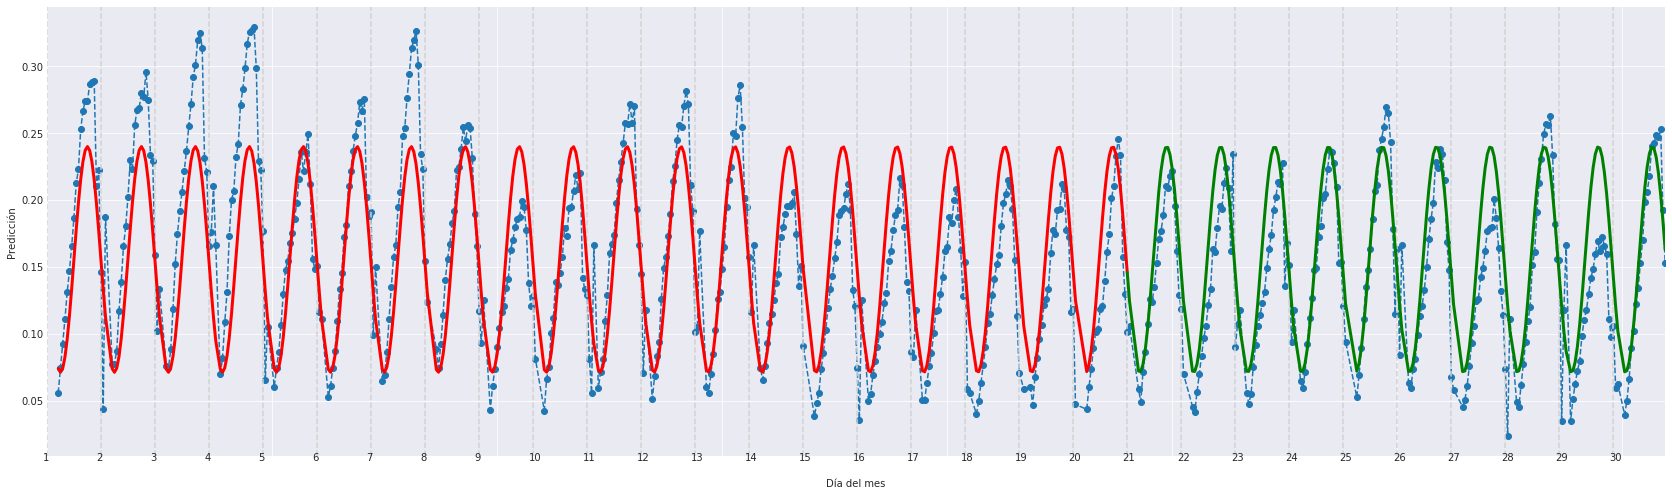

ECM: 0.0011903109527406017


In [30]:
func = lambda t: [np.sin(freq * t), 1]
ecm, _ = predict(2002, 4, 0, 20, 10, func)
plt.show()
print("ECM: {}".format(ecm))

Hacemos validación cruzada de nuevo:

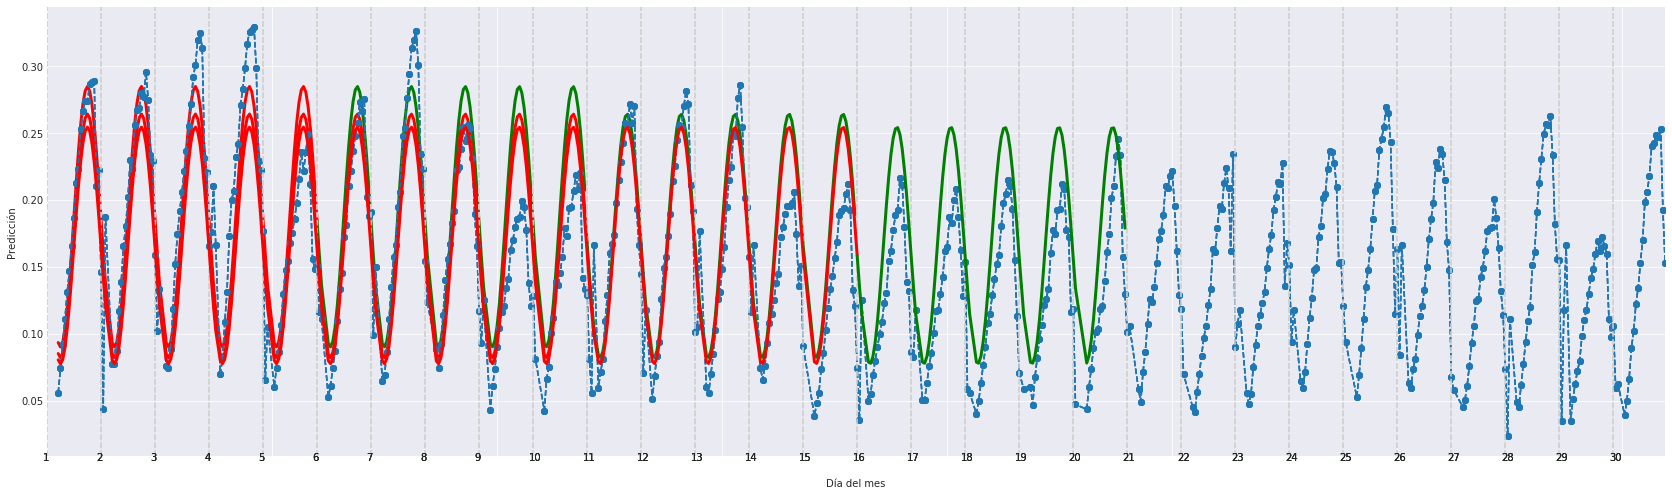

ECM Promedio: 0.0019806920505389763


In [31]:
ecms = crossval(2002, 4, 0, func)
plt.show();
print("ECM Promedio: {}".format(ecms.mean()))

# Entonces...

In [33]:
ecms = crossval(2002, 1, 0, func)
print("ECM Enero: {}".format(ecms.mean()))

ecms = crossval(2002, 4, 0, func)
print("ECM Abril: {}".format(ecms.mean()))

ecms = crossval(2002, 11, 0, func)
print("ECM Noviembre: {}".format(ecms.mean()))

ecms = crossval(2002, 12, 0, func)
print("ECM Diciembre: {}".format(ecms.mean()))

ECM Enero: 0.008043264408391768
ECM Abril: 0.0019806920505389763
ECM Noviembre: 0.0013268471663523886
ECM Diciembre: 0.0044770459518830965
